Consider two tasks: check if running shoes from RunPro 3000 do make a difference (50-50 means as total average the shoes should be normalised, to be checked if that is also true per attribute).

Attributes are the following:
* age group
* country
* male or female

Second task: try to predict the finishing time of the Marathon as part of the attributes.

So technically task 1 is a classification problem, task 2 is a regression problem

In [4]:
import pandas as pd
import numpy as np

In [4]:
df_attributes=pd.read_csv("datasets/RunningShoes_Challenge/data/runner_attributes.csv")
df_time=pd.read_csv("datasets/RunningShoes_Challenge/data/marathon_times.csv")
#checked for dimension, checked what we see in duplicates

OK there seem to be duplicates based on Runner's ID,some which have also the same attributes for everything. The runner's time and the attributes have also different dimensions, but all which are at the end are in my Treatment group, also when i check for duplicates on all attributes with left merge, all indices above 30373 (the dimension of the runners times) seem to be duplicates on attributes. Times don't have ANY duplicates.

We checked that indeed the uniqueID might not be unique, both on attributes and the times files. BUT it is true in that fact that the times are different for the same uniqueID, so maybe values have been entered wrongly.

Also checked: unique_id in attributes and unique_id in times are identical in the same order, all ID's beyond the rows of the times are in fact full duplicates of attributes listed before: Assume from now on that these are in fact real duplicates and can be safely ignored.


In [5]:
df_merged=df_attributes.join(df_time, lsuffix='_attr', rsuffix='_tim')
#df_merged=df_merged.drop([df_merged.columns[0]], axis='columns')
df_merged.to_csv('df_test.csv')
#print(df_merged.head())
df_merged['unique_id'] = np.where((df_merged['unique_id_attr'] == df_merged['unique_id_tim'])
                     , df_merged['unique_id_attr'], np.NaN)
df_merged.to_csv('df_merged_attributes_time_nodrop.csv')
#do opposite selection JUST to be sure
df_merged['unique_id'] = np.where((df_merged['unique_id_attr'] == df_merged['unique_id_tim'])
                     , df_merged['unique_id_attr'], np.NaN)
#drop columns for times
df_merged=df_merged.drop(columns=['unique_id_attr', 'unique_id_tim'])
df_merged=df_merged.dropna(axis=0)
df_merged.shape
df_merged.treatment.replace(['Treatment', 'Control'], [1, 0], inplace=True)
df_merged.ageClass.replace(['U20'], [15], inplace=True)
df_merged.sex.replace(['M', 'W'], [0, 1], inplace=True)
df_merged.to_csv('df_merged_after_transform.csv')
df_merged['ageClass']=df_merged['ageClass'].astype(int)
#df_merged.plot.bar()
ageClass_values=df_merged['ageClass'].unique()
print(ageClass_values)
nationalities=df_merged['nationality'].unique()
print(nationalities.shape,nationalities)
counts_nationality=df_merged.nationality.value_counts()
#counts_nationality[0:10].plot(kind='bar')
print(counts_nationality)

[20 30 35 45 40 50 55 15 60 65 70 75 80]
(92,) ['KEN' 'ETH' 'AUS' 'BRA' 'KOR' 'JPN' 'GBR' 'USA' 'ITA' 'ISR' 'FRA' 'EST'
 'DEU' 'CHE' 'ZAF' 'FIN' 'NOR' 'DNK' 'ESP' 'BEL' 'HUN' 'SWE' 'NLD' 'AUT'
 'EGY' 'RUS' 'CAN' 'POL' 'ISL' 'MLT' 'IRL' 'GAN' 'VEN' 'PRT' 'MEX' 'SVN'
 'AGO' 'CHL' 'LUX' 'DZA' 'LIE' 'CZE' 'CRI' 'TUR' 'KZK' 'IND' 'NZL' 'HRV'
 'ECU' 'BGR' 'GRC' 'CUB' 'PER' 'SLV' 'YUG' 'NIC' 'COL' 'MAR' 'MKO' 'COM'
 'IRN' 'PRI' 'SGP' 'DOM' 'BOL' 'LBR' 'SEN' 'ARG' 'GHA' 'LBN' 'BIH' 'LVA'
 'ALB' 'LTU' 'ISI' 'PAK' 'AFG' 'MUS' 'SVK' 'CHN' 'TWN' 'MLI' 'CYP' 'AHO'
 'ROU' 'IDN' 'BLR' 'FLK' 'THA' 'SDN' 'NGA' 'PHL']
DEU    20909
DNK     1873
NLD      906
GBR      894
CHE      767
       ...  
LTU        1
LBR        1
MUS        1
LBN        1
CUB        1
Name: nationality, Length: 92, dtype: int64


In [1]:
import uproot
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import math 
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [124]:
df_target=pd.read_csv("datasets/RunningShoes_Challenge/data/marathon_times.csv")
print(df_target.shape[0])
df_variables=pd.read_csv("datasets/RunningShoes_Challenge/data/runner_attributes.csv")
#time_values=df_merged_time.pop('netTime').values
#print(time_values)
df_variables=df_variables.truncate(after=(df_target.shape[0]-1))
#drop all columns above the target values
#df_variables=df_variables.drop(df_variables.index[range((index_low+1), index_high)],axis=0,  inplace=True)
df_time_values=df_target['netTime']
df_variables.treatment.replace(['Treatment', 'Control'], [1, 0], inplace=True)
df_variables.ageClass.replace(['U20'], [15], inplace=True)
df_variables.sex.replace(['M', 'W'], [0, 1], inplace=True)
df_X_input=df_variables[['ageClass','sex','treatment','nationality']]
df_variables=df_variables.drop(["unique_id"],axis=1)
df_X_input_v2=df_merged[['ageClass','sex','treatment']]
print(df_X_input_v2)
print(time_values)
y_polm80_total=np.ones(df_target.shape[0])
train_test_split = 0.25

30373
       ageClass  sex  treatment
0            20    0          1
1            20    0          1
2            20    0          0
3            30    0          0
4            30    0          1
...         ...  ...        ...
30368        20    0          1
30369        45    0          1
30370        60    0          0
30371        80    0          0
30372        75    0          1

[30373 rows x 3 columns]
0         7661
1         7737
2         7747
3         7750
4         8163
         ...  
30368    24513
30369    24460
30370    24934
30371    24952
30372    24370
Name: netTime, Length: 30373, dtype: int64


TypeError: 'float' object is not callable

32942.0 -1000.0 5833.0
16189.215384615385 16423.904231625835 6192977.358793629 7389528.43946866


,ageClass,sex,nationality,treatment,netTime,clockTime,unique_id
7216,35,0,DEU,0,-1000.0,-1000.0,b25e26a1f07e91dfe8aba37b3ad1086ab0486f6d
10391,30,0,FRA,0,-1000.0,-1000.0,ca7e2627a9ad4bc4967a14c4c25aaa1c81e95a78
12504,20,1,DNK,0,-1000.0,-1000.0,737cada79eafc903e545ef32045f4d18d4851af0
23642,45,1,CHE,0,-1000.0,-1000.0,ba026abf6d8601654ae679b642417bacae9bbc0b
27679,35,0,DEU,0,-1000.0,-1000.0,6e39f54099429845c013e3f5aff9ee6658901023


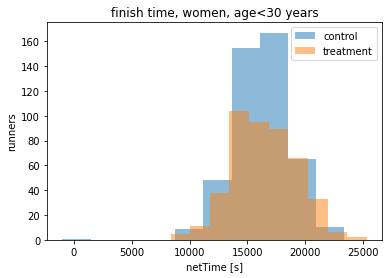

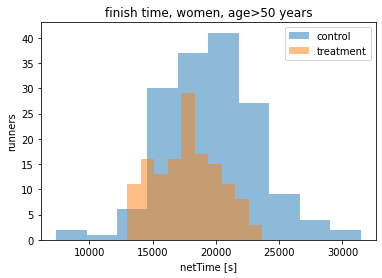

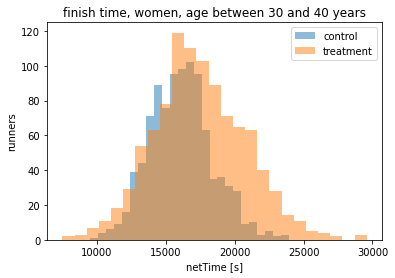

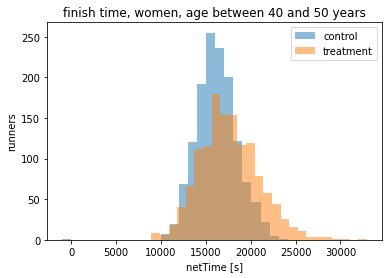

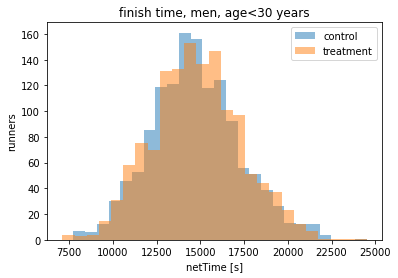

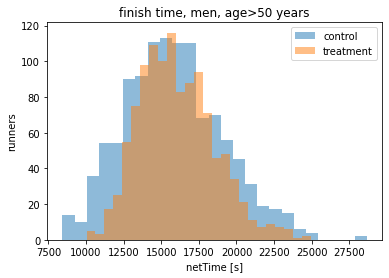

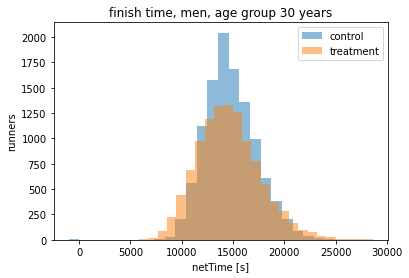

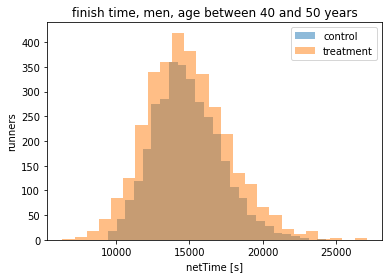

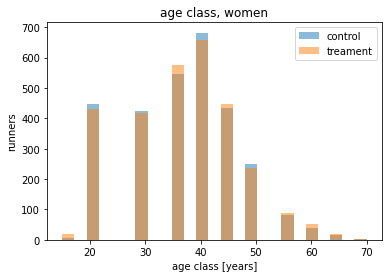

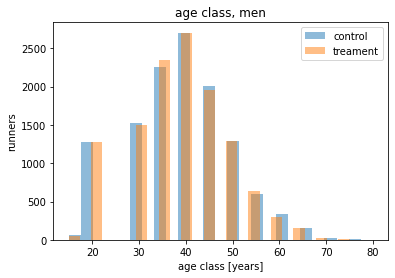

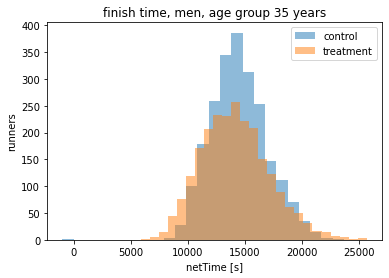

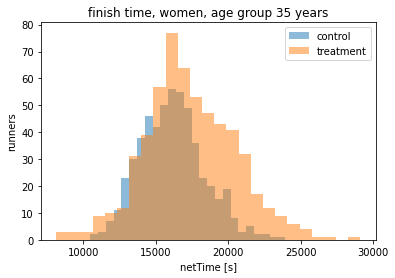

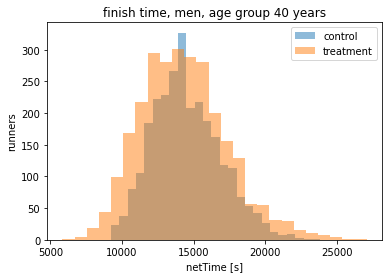

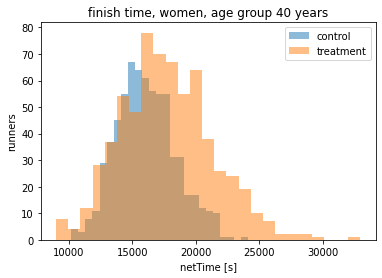

In [33]:
print (df_merged['netTime'].max(),df_merged['netTime'].min(),df_merged[df_merged['netTime']>0]['netTime'].min())
bins_test=np.linspace(df_merged[df_merged['netTime']>0]['netTime'].min(),df_merged['netTime'].max(),50)

plt.figure(1)
hist_f_b30_c=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].plot.hist(bins_test,alpha=0.5,label="control")
hist_f_b30_f=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].plot.hist(bins_test,alpha=0.5,label="treatment")

mean_c=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].mean()
mean_t=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].mean()
var_c=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].var()
var_t=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].var()
print(mean_c,mean_t,var_c,var_t)


plt.title("finish time, women, age<30 years")
plt.xlabel("netTime [s]")
plt.ylabel("runners")
plt.legend()
plt.figure(2)
hist_f_a50_f=df_merged[(df_merged['ageClass']>50) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].plot.hist(bins_test,alpha=0.5,label="control")
hist_f_a50_c=df_merged[(df_merged['ageClass']>50) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].plot.hist(bins_test,alpha=0.5,label="treatment")
plt.title("finish time, women, age>50 years")
plt.xlabel("netTime [s]")
plt.ylabel("runners")
plt.legend()
plt.figure(3)
hist_f_b30_c=df_merged[(df_merged['ageClass']>=30) & (df_merged['ageClass']<40) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].plot.hist(bins=25,alpha=0.5,label="control")
hist_f_b30_f=df_merged[(df_merged['ageClass']>=30) & (df_merged['ageClass']<40)& (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].plot.hist(bins=25,alpha=0.5,label="treatment")
plt.title("finish time, women, age between 30 and 40 years")
plt.xlabel("netTime [s]")
plt.ylabel("runners")
plt.legend()
plt.figure(4)
hist_f_b30_c=df_merged[(df_merged['ageClass']>=40) & (df_merged['ageClass']<=50) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].plot.hist(bins=25,alpha=0.5,label="control")
hist_f_b30_f=df_merged[(df_merged['ageClass']>=40) & (df_merged['ageClass']<=50)& (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].plot.hist(bins=25,alpha=0.5,label="treatment")
plt.title("finish time, women, age between 40 and 50 years")
plt.xlabel("netTime [s]")
plt.ylabel("runners")
plt.legend()
plt.figure(5)
hist_f_b30_c=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"].plot.hist(bins=25,alpha=0.5,label="control")
hist_f_b30_f=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"].plot.hist(bins=25,alpha=0.5,label="treatment")
plt.title("finish time, men, age<30 years")
plt.xlabel("netTime [s]")
plt.ylabel("runners")
plt.legend()
plt.figure(6)
hist_f_a50_f=df_merged[(df_merged['ageClass']>50) & (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"].plot.hist(bins=25,alpha=0.5,label="control")
hist_f_a50_c=df_merged[(df_merged['ageClass']>50) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"].plot.hist(bins=25,alpha=0.5,label="treatment")
plt.title("finish time, men, age>50 years")
plt.xlabel("netTime [s]")
plt.ylabel("runners")
plt.legend()
plt.figure(7)
hist_f_b30_c=df_merged[(df_merged['ageClass']>=30)  & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"].plot.hist(bins=25,alpha=0.5,label="control")
hist_f_b30_f=df_merged[(df_merged['ageClass']>=30) & (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"].plot.hist(bins=25,alpha=0.5,label="treatment")
plt.title("finish time, men, age group 30 years")
plt.xlabel("netTime [s]")
plt.ylabel("runners")
plt.legend()
plt.figure(8)
hist_f_b30_c=df_merged[(df_merged['ageClass']>=45) & (df_merged['ageClass']<=50) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"].plot.hist(bins=25,alpha=0.5,label="control")
hist_f_b30_f=df_merged[(df_merged['ageClass']>=45) & (df_merged['ageClass']<=50)& (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"].plot.hist(bins=25,alpha=0.5,label="treatment")
plt.title("finish time, men, age between 40 and 50 years")
plt.xlabel("netTime [s]")
plt.ylabel("runners")
plt.legend()

plt.figure(9)
hist_f_b30_c=df_merged[(df_merged['sex']==1)& (df_merged['treatment']==0)]["ageClass"].plot.hist(bins=25,alpha=0.5,label="control")
hist_f_b30_t=df_merged[(df_merged['sex']==1)& (df_merged['treatment']==1)]["ageClass"].plot.hist(bins=25,alpha=0.5,label="treament")
plt.title("age class, women")
plt.xlabel("age class [years]")
plt.ylabel("runners")
plt.legend()
plt.figure(10)
hist_f_b30_c=df_merged[(df_merged['sex']==0)& (df_merged['treatment']==0)]["ageClass"].plot.hist(bins=25,alpha=0.5,label="control")
hist_f_b30_t=df_merged[(df_merged['sex']==0)& (df_merged['treatment']==1)]["ageClass"].plot.hist(bins=25,alpha=0.5,label="treament")
plt.title("age class, men")
plt.xlabel("age class [years]")
plt.ylabel("runners")
plt.legend()
plt.figure(11)
hist_f_b30_c=df_merged[(df_merged['ageClass']==35) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"].plot.hist(bins=25,alpha=0.5,label="control")
hist_f_b30_f=df_merged[(df_merged['ageClass']==35)& (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"].plot.hist(bins=25,alpha=0.5,label="treatment")
plt.title("finish time, men, age group 35 years")
plt.xlabel("netTime [s]")
plt.ylabel("runners")
plt.legend()
plt.figure(12)
hist_f_b30_c=df_merged[(df_merged['ageClass']==35) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].plot.hist(bins=25,alpha=0.5,label="control")
hist_f_b30_f=df_merged[(df_merged['ageClass']==35)& (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].plot.hist(bins=25,alpha=0.5,label="treatment")
plt.title("finish time, women, age group 35 years")
plt.xlabel("netTime [s]")
plt.ylabel("runners")
plt.legend()
plt.figure(13)
hist_f_b30_c=df_merged[(df_merged['ageClass']==40) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"].plot.hist(bins=25,alpha=0.5,label="control")
hist_f_b30_f=df_merged[(df_merged['ageClass']==40)& (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"].plot.hist(bins=25,alpha=0.5,label="treatment")
plt.title("finish time, men, age group 40 years")
plt.xlabel("netTime [s]")
plt.ylabel("runners")
plt.legend()
plt.figure(14)
hist_f_b30_c=df_merged[(df_merged['ageClass']==40) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].plot.hist(bins=25,alpha=0.5,label="control")
hist_f_b30_f=df_merged[(df_merged['ageClass']==40)& (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].plot.hist(bins=25,alpha=0.5,label="treatment")
plt.title("finish time, women, age group 40 years")
plt.xlabel("netTime [s]")
plt.ylabel("runners")
plt.legend()

df_weird=df_merged[(df_merged['netTime']<1000)]
df_weird.head()

In [34]:
from scipy.stats import ks_2samp
from scipy.stats import kstest

control=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"]
test=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"]
mean_c=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].mean()
mean_t=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].mean()
var_c=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].var()
var_t=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].var()
#output is test statistic,p-value
print("w,<30",ks_2samp(control,test),"mean c,t",mean_c,mean_t,"var_c,vart",math.sqrt(var_c),math.sqrt(var_t))

control=df_merged[(df_merged['ageClass']>55) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"]
test=df_merged[(df_merged['ageClass']>55) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"]
mean_c=df_merged[(df_merged['ageClass']>55) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].mean()
mean_t=df_merged[(df_merged['ageClass']>55) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].mean()
var_c=df_merged[(df_merged['ageClass']>55) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].var()
var_t=df_merged[(df_merged['ageClass']>55) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].var()
#output is test statistic,p-value
print("w,>55",ks_2samp(control,test),"mean c,t",mean_c,mean_t,"var_c,vart",math.sqrt(var_c),math.sqrt(var_t))

control=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"]
test=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"]
mean_c=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"].mean()
mean_t=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"].mean()
var_c=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"].var()
var_t=df_merged[(df_merged['ageClass']<30) & (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"].var()
#output is test statistic,p-value
print("m,<30",ks_2samp(control,test),"mean c,t",mean_c,mean_t,"var_c,vart",math.sqrt(var_c),math.sqrt(var_t))

control=df_merged[(df_merged['ageClass']>55) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"]
test=df_merged[(df_merged['ageClass']>55) & (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"]
mean_c=df_merged[(df_merged['ageClass']>55) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"].mean()
mean_t=df_merged[(df_merged['ageClass']>55) & (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"].mean()
var_c=df_merged[(df_merged['ageClass']>55) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"].var()
var_t=df_merged[(df_merged['ageClass']>55) & (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"].var()
#output is test statistic,p-value
print("m,>55",ks_2samp(control,test),"mean c,t",mean_c,mean_t,"var_c,vart",math.sqrt(var_c),math.sqrt(var_t))

control=df_merged[(df_merged['ageClass']>=30) & (df_merged['ageClass']<40) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"]
test=df_merged[(df_merged['ageClass']>=30) & (df_merged['ageClass']<40) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"]
mean_c=df_merged[(df_merged['ageClass']>=30) & (df_merged['ageClass']<40) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].mean()
mean_t=df_merged[(df_merged['ageClass']>=30) & (df_merged['ageClass']<40) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].mean()
var_c=df_merged[(df_merged['ageClass']>=30) & (df_merged['ageClass']<40) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].var()
var_t=df_merged[(df_merged['ageClass']>=30) & (df_merged['ageClass']<40) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].var()
#output is test statistic,p-value
print("f,30-40",ks_2samp(control,test),"mean c,t",mean_c,mean_t,"var_c,vart",math.sqrt(var_c),math.sqrt(var_t))

control=df_merged[(df_merged['ageClass']>=30) & (df_merged['ageClass']<35) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"]
test=df_merged[(df_merged['ageClass']>=30) & (df_merged['ageClass']<35) & (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"]
mean_c=df_merged[(df_merged['ageClass']>=30) & (df_merged['ageClass']<35) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"].mean()
mean_t=df_merged[(df_merged['ageClass']>=30) & (df_merged['ageClass']<35) & (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"].mean()
var_c=df_merged[(df_merged['ageClass']>=30) & (df_merged['ageClass']<35) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"].var()
var_t=df_merged[(df_merged['ageClass']>=30) & (df_merged['ageClass']<35) & (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"].var()
#output is test statistic,p-value
print("m,30-<40",ks_2samp(control,test),"mean c,t",mean_c,mean_t,"var_c,vart",math.sqrt(var_c),math.sqrt(var_t))

control=df_merged[(df_merged['ageClass']==35) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"]
test=df_merged[(df_merged['ageClass']==35) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"]
mean_c=df_merged[(df_merged['ageClass']==35) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].mean()
mean_t=df_merged[(df_merged['ageClass']==35) &(df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].mean()
var_c=df_merged[(df_merged['ageClass']==35) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].var()
var_t=df_merged[(df_merged['ageClass']==35) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].var()
#output is test statistic,p-value
print("f,age=35",ks_2samp(control,test),"mean c,t",mean_c,mean_t,"var_c,vart",math.sqrt(var_c),math.sqrt(var_t))


control=df_merged[(df_merged['ageClass']==35) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"]
test=df_merged[(df_merged['ageClass']==35) & (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"]
mean_c=df_merged[(df_merged['ageClass']==35) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"].mean()
mean_t=df_merged[(df_merged['ageClass']==35) &(df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"].mean()
var_c=df_merged[(df_merged['ageClass']==35) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"].var()
var_t=df_merged[(df_merged['ageClass']==35) & (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"].var()
#output is test statistic,p-value
print("m,age=35",ks_2samp(control,test),"mean c,t",mean_c,mean_t,"var_c,vart",math.sqrt(var_c),math.sqrt(var_t))

control=df_merged[(df_merged['ageClass']==40) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"]
test=df_merged[(df_merged['ageClass']==40) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"]
mean_c=df_merged[(df_merged['ageClass']==40) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].mean()
mean_t=df_merged[(df_merged['ageClass']==40) &(df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].mean()
var_c=df_merged[(df_merged['ageClass']==40) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].var()
var_t=df_merged[(df_merged['ageClass']==40) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].var()
#output is test statistic,p-value
print("f,age=40",ks_2samp(control,test),"mean c,t",mean_c,mean_t,"var_c,vart",math.sqrt(var_c),math.sqrt(var_t))

control=df_merged[(df_merged['ageClass']==40) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"]
test=df_merged[(df_merged['ageClass']==40) & (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"]
mean_c=df_merged[(df_merged['ageClass']==40) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"].mean()
mean_t=df_merged[(df_merged['ageClass']==40) &(df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"].mean()
var_c=df_merged[(df_merged['ageClass']==40) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"].var()
var_t=df_merged[(df_merged['ageClass']==40) & (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"].var()
#output is test statistic,p-value
print("m,age=40",ks_2samp(control,test),"mean c,t",mean_c,mean_t,"var_c,vart",math.sqrt(var_c),math.sqrt(var_t))

control=df_merged[(df_merged['ageClass']>=45) & (df_merged['ageClass']<55) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"]
test=df_merged[(df_merged['ageClass']>=45) & (df_merged['ageClass']<55) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"]
mean_c=df_merged[(df_merged['ageClass']>=45) & (df_merged['ageClass']<55) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].mean()
mean_t=df_merged[(df_merged['ageClass']>=45) & (df_merged['ageClass']<55) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].mean()
var_c=df_merged[(df_merged['ageClass']>=45) & (df_merged['ageClass']<55) & (df_merged['sex']==1) & (df_merged['treatment']==0)]["netTime"].var()
var_t=df_merged[(df_merged['ageClass']>=45) & (df_merged['ageClass']<55) & (df_merged['sex']==1) & (df_merged['treatment']==1)]["netTime"].var()
#output is test statistic,p-value
print("f,40<=age<=50",ks_2samp(control,test),"mean c,t",mean_c,mean_t,"var_c,vart",math.sqrt(var_c),math.sqrt(var_t))

control=df_merged[(df_merged['ageClass']>=40) & (df_merged['ageClass']<55) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"]
test=df_merged[(df_merged['ageClass']>=40) & (df_merged['ageClass']<55) & (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"]
mean_c=df_merged[(df_merged['ageClass']>=40) & (df_merged['ageClass']<55) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"].mean()
mean_t=df_merged[(df_merged['ageClass']>=40) & (df_merged['ageClass']<55) & (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"].mean()
var_c=df_merged[(df_merged['ageClass']>=40) & (df_merged['ageClass']<55) & (df_merged['sex']==0) & (df_merged['treatment']==0)]["netTime"].var()
var_t=df_merged[(df_merged['ageClass']>=40) & (df_merged['ageClass']<55) & (df_merged['sex']==0) & (df_merged['treatment']==1)]["netTime"].var()
#output is test statistic,p-value
print("m,40<=age<=50",ks_2samp(control,test),"mean c,t",mean_c,mean_t,"var_c,vart",math.sqrt(var_c),math.sqrt(var_t))

w,<30 Ks_2sampResult(statistic=0.09316429672777111, pvalue=0.036155146630212354) mean c,t 16189.215384615385 16423.904231625835 var_c,vart 2488.5693397600216 2718.368709257201
w,>55 Ks_2sampResult(statistic=0.22409456740442657, pvalue=0.07092292134703215) mean c,t 18338.125 19789.211267605635 var_c,vart 2391.3046729006246 3496.0370336200185
m,<30 Ks_2sampResult(statistic=0.04327162802293692, pvalue=0.1558267275071873) mean c,t 14713.308779761905 14807.43081525804 var_c,vart 2537.679594949739 2535.375782044046
m,>55 Ks_2sampResult(statistic=0.10491219588930198, pvalue=0.0065983165878805705) mean c,t 16656.50281425891 16553.856850715747 var_c,vart 2476.598388421033 3400.404205113683
f,30-40 Ks_2sampResult(statistic=0.22890962753574992, pvalue=9.535699794119378e-23) mean c,t 16117.476288659795 17464.4122983871 var_c,vart 2285.965761624063 3362.875983483868
m,30-<40 Ks_2sampResult(statistic=0.09888063468154004, pvalue=6.957527489692694e-07) mean c,t 14435.560446780552 14236.373413493655 va

Comparing the distributions for age group 40 and age group 50, particularly for men the distributions seem to be pretty alike. In general the mean times of runners with the shoes are larger than for the control sample. only for seniors male the shoes (aka treatment) is better, and for women of the age range 

Text(0, 0.5, 'runners')

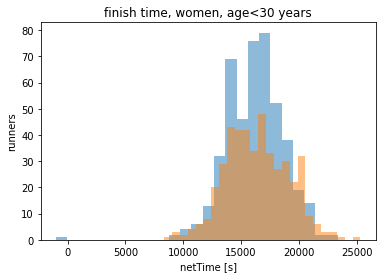

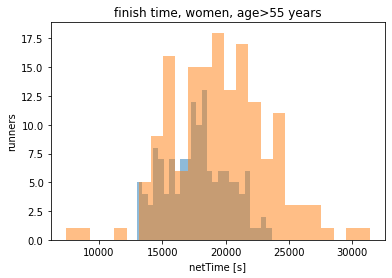

In [11]:
#print(ax_list_treat.shape)
df_treat=df_merged[df_merged["treatment"]==1]
df_cont=df_merged[df_merged["treatment"]==0]
#df_treat.to_csv('df_merged_treat.csv')
#df_cont.to_csv('df_merged_contr.csv')

#nbins_ages = np.linspace(12.5,87.5,15)
#h_age_treat = plt.hist(ages_treat_arr, nbins_ages, alpha=0.5,label='treatment')
#plt.show()
#hist_age_t=df_treat['ageClass'].plot.hist(alpha=0.5,bins=16)
#ax_list_treat=hist_age_t
#ax_list_treat.set_xlim(7.5,87.5)
#df_cont['ageClass'].value_counts().plot(kind="bar")
#df_treat['ageClass'].value_counts().plot(kind="bar")
plt.figure(1)
hist_f_b30_c=df_cont[(df_cont['ageClass']<30) & (df_cont['sex']==1)]["netTime"].plot.hist(bins=25,alpha=0.5)
hist_f_b30_f=df_treat[(df_treat['ageClass']<30) & (df_treat['sex']==1)]["netTime"].plot.hist(bins=25,alpha=0.5)
plt.title("finish time, women, age<30 years")
plt.xlabel("netTime [s]")
plt.ylabel("runners")
plt.figure(2)
hist_f_b30_c=df_cont[(df_cont['ageClass']>50) & (df_cont['sex']==1)]["netTime"].plot.hist(bins=25,alpha=0.5)
hist_f_b30_f=df_treat[(df_treat['ageClass']>50) & (df_treat['sex']==1)]["netTime"].plot.hist(bins=25,alpha=0.5)
plt.title("finish time, women, age>55 years")
plt.xlabel("netTime [s]")
plt.ylabel("runners")

We want to study netTime as function dependent on Treatment or Control, for easier representation we put sex M=0, F=1, age_class has U20 for below 20's put that to 10 to make it an integer as well, Control and Treatment we put to 0 and 1 as well.

In [51]:
#sanity check if data is actually of the same length (aka if we do see same entries for the times and the attribtues)
df_time.shape, df_attributes.shape
#result shows no: 30923 people started, but only 30373 people finished
#treat runners who didn't finish separately
#now try an inner join
df_merged=pd.merge(df_attributes,df_time, how='outer',on="unique_id")
df_merged.shape #32397 with inner merge, so more than i would guess from overlap, so what is wrong
df_merged.to_csv('attributes_times_merged.csv')
#seems some unique id's are not THAT unique after all, also don't find NAN's in times, so check again
duplicate_rows_times = df_time[df_time.duplicated()]
#print(duplicate_rows_times)
#seems no duplicates found for times
duplicate_rows_attributes_all = df_attributes[df_attributes.duplicated()]
duplicate_rows_attributes_id = df_attributes[df_attributes.duplicated("unique_id")]
print(duplicate_rows_attributes) #seems we do have quite a bit of duplicates here, so get rid
#619 rows printed, but with unique_id 1104 rows are printed
#checked now there ARE different attributes to the same unique ID, also different times, so 
duplicate_difference_all_id=pd.concat([duplicate_rows_attributes_all,duplicate_rows_attributes_id]).drop_duplicates(keep=False)
df_difference = duplicate_rows_attributes_id.merge(duplicate_rows_attributes_all, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']
print(df_difference) #seems we do have quite a bit of duplicates here, so get rid
df_difference.to_csv('difference_duplicate.csv')
duplicate_rows_attributes_all.to_csv('attributes_duplicate_all.csv')
duplicate_rows_attributes_id.to_csv('attributes_duplicate_id.csv')
#all dtypes are objects, so let's try to change it into numbers to work easier (bar the unique_id, which we need for merging later)
#df_attributes.dtypes

      ageClass sex nationality  treatment  \
1260        50   M         DEU    Control   
1625        40   M         DEU    Control   
1873        50   M         DEU    Control   
2193        35   M         DEU    Control   
2524        30   M         DNK    Control   
...        ...  ..         ...        ...   
30918       35   M         DEU  Treatment   
30919       30   M         DEU  Treatment   
30920       75   M         DEU  Treatment   
30921       35   M         GBR  Treatment   
30922       35   M         DEU  Treatment   

                                      unique_id  
1260   c4e71d72497e554239cd93fd385f141cfde59508  
1625   074065ca08d69bd8a17245d8bd1482edd272be83  
1873   4a2d38b16728b6438415c74dfaef04d5d591d670  
2193   0829260bbeeeafa6996558e143a972093d456151  
2524   542fd6e396e470eddf97734b87f5ad1a96cd0704  
...                                         ...  
30918  761da858332d4d4372bb716ed2eb29835203fe7e  
30919  cc5f2231a015ab7a238fc15a58cd5372e135fd27  
30920  4a

NameError: name 'df_merged_' is not defined

In [ ]:
df_merged_attributes_times_no_duplicate_rm=df_attributes.join(df_time, lsuffix='_attr', rsuffix='_tim')
df_merged_attributes_times_no_duplicate_rm.to_csv('df_merged.csv')
df_merged_attributes_times_no_duplicate_rm['unique_id'] = np.where((df_merged_attributes_times_no_duplicate_rm['unique_id_attr'] == df_merged_attributes_times_no_duplicate_rm['unique_id_tim'])
                     , df_merged_attributes_times_no_duplicate_rm['unique_id_attr'], np.NaN)
df_merged_attributes_times_no_duplicate_rm.to_csv('df_merged_2.csv')
df_merged_attributes_times_no_duplicate_rm.shape
#30923 (rows) x9 as we wanted, same as attributes
df_merged_attributes_times_no_duplicate_rm.isna().sum()
#indeed comparing the unique_id, which checked if attribute and time ID are identical lists 550, aka the same amount of
#rows missing
#do opposite selection JUST to be sure
df_merged_attributes_times_no_duplicate_rm['unique_id'] = np.where((df_merged_attributes_times_no_duplicate_rm['unique_id_attr'] != df_merged_attributes_times_no_duplicate_rm['unique_id_tim'])
                     , df_merged_attributes_times_no_duplicate_rm['unique_id_attr'], np.NaN)
df_merged_attributes_times_no_duplicate_rm.isna().sum()
#opposite selection gives 30373, THUS we checked that indeed by using an index join we do keep the order correct